In [1]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

from tqdm import tqdm
import os
import cv2

from PIL import Image
from classification.model import ResNet, BasicBlock
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [7]:
## Make sure you work in Mask4VTON directory
!pwd
%cd Mask4VTON

/home/zhuominc/leo/Mask4VTON
[Errno 2] No such file or directory: 'Mask4VTON'
/home/zhuominc/leo/Mask4VTON
/home/zhuominc/leo/Mask4VTON


In [8]:
!cp custom_ssseg/inference.py sssegmentation/ssseg/
!cp custom_ssseg/base_cfg.py sssegmentation/ssseg/configs/mask2former
!cp custom_ssseg/mask2former_cihp.py sssegmentation/ssseg/configs/mask2former
!cp -r custom_ssseg/CIHP sssegmentation

## Config

In [ ]:
cls_ori_classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
cls_custom_classes = {
    "top": ['T-shirt/top','Shirt','Pullover'], # only upper body
    "long-pants": ['Trouser'], # pants and legs
    "shorts": ['Shorts'], # pants only
    "shoes": ['Sandal','Sneaker','Ankle Boot'],
    "Above-knee": ['Dress', 'Coat'], # whole body
    "whole-body": []
}


cls_ckptspath = "checkpoints/cls_resnet.pth"
seg_ckptspath = "checkpoints/seg_mask2former.pth"
person_img_dir = "../persons"
clothes_img_dir = "../clothes"

## TODO: MODIFY YOUR IMAGE PATH
## Image file should be one of the following format: jpg, jpeg, png
## Important: clothes image must have a white background in this method 
## due the limitation of my classification model
person_file = "person2.jpg"
clothes_file = "short_dress.jpg"


person_img_path = os.path.join(person_img_dir, person_file)
clothes_img_path = os.path.join(clothes_img_dir, clothes_file)
output_dir = "../person_seg"

## Product Image Classification

/tmp/ipykernel_1541691/3043975391.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


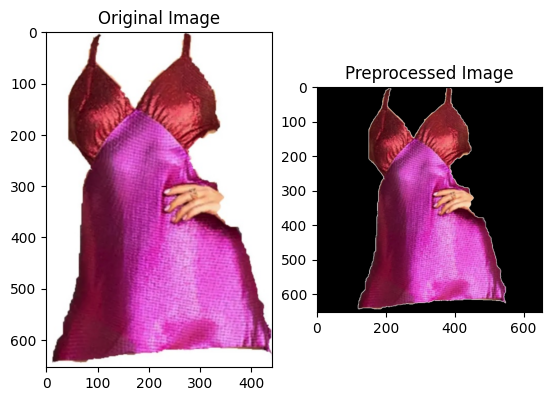

Predicted class: Dress
Custom class: Above-knee


In [12]:
def make_square(image):
    # Get original dimensions
    h, w = image.shape[:2]

    # Calculate padding sizes to make it square
    if h > w:
        diff = h - w
        pad_left = diff // 2
        pad_right = diff - pad_left
        pad_top, pad_bottom = 0, 0
    else:
        diff = w - h
        pad_top = diff // 2
        pad_bottom = diff - pad_top
        pad_left, pad_right = 0, 0

    # Apply border replication padding
    padded_image = cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    return padded_image

def get_bounding_box(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image to get binary representation
    _, binary = cv2.threshold(blurred, 230, 255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get the bounding box of the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Draw the bounding box on the original image

    return binary, (w, h)

def image_preprocess(image_path):

    ori_image = cv2.imread(image_path[1:])

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    image = make_square(ori_image)
    binary, (obj_w, obj_h) = get_bounding_box(image)
    
    mask = np.where(binary == 0, 0, 1).astype('uint8')
    image = image * mask[:, :, np.newaxis]
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Preprocessed Image")
    plt.show()

    image = Image.fromarray(image)
    tranform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((36, 36)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    image = tranform(image).unsqueeze(0)

    ratio = obj_h / obj_w

    return image, ratio

def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    return model


model = ResNet(BasicBlock, [2, 2, 2, 3])
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
model = model.to(DEVICE)

model = load_model(model, cls_ckptspath)
model.eval()

image, ratio = image_preprocess(clothes_img_path)
output = model(image.to(DEVICE))
pred = output.argmax(dim=1, keepdim=True)

class_name = cls_ori_classes[pred.item()]
print("Predicted class:", class_name)

if class_name == "T-shirt/top" or class_name == "Pullover" or class_name == "Shirt":
    class_name = "top"
elif class_name == "Trouser":
    if ratio > 1.5:
        class_name = "long-pants"
    else:
        class_name = "shorts"
elif class_name == "Dress" or class_name == "Coat":
    if ratio > 1.5:
        class_name = "whole-body"
    else:
        class_name = "Above-knee"
elif class_name == "Sandal" or class_name == "Sneaker" or class_name == "Ankle Boot":
    class_name = "shoes"
else:
    class_name = "shorts" ## there should no bag be input and after observing the dataset, shorts is the most similar class to bag
print("Custom class:", class_name)

In [13]:
person_file_name = person_img_path.split("/")[-1].split(".")[0]
if not os.path.exists(os.path.join(output_dir[1:], person_file_name)):
    os.system(f"bash ./sssegmentation/scripts/inference.sh ssseg/configs/mask2former/mask2former_cihp.py ../{seg_ckptspath} --imagepath {person_img_path} --outputdir {output_dir}")

/home/zhuominc/anaconda3/envs/ssseg/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


Start to inference...


Processing ../persons/person2.jpg:   0%|          | 0/1 [00:00<?, ?it/s]

base path:  ../person_seg/person2


Processing ../persons/person2.jpg: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Text(0.5, 1.0, 'Color Mask')

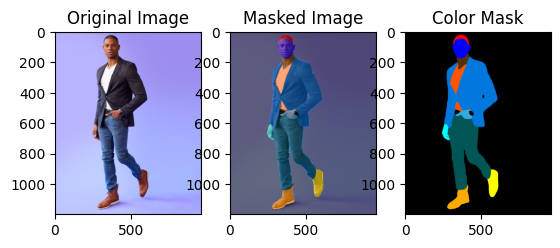

In [14]:
ori_image = cv2.imread(person_img_path[1:])
masked_image = cv2.imread(os.path.join(output_dir.split("/")[-1], person_file_name, "image_mask.png"))
color_mask = cv2.imread(os.path.join(output_dir.split("/")[-1], person_file_name, "color_mask.png"))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title("Masked Image")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB))
plt.title("Color Mask")

Text(0.5, 1.0, 'Segmented Image')

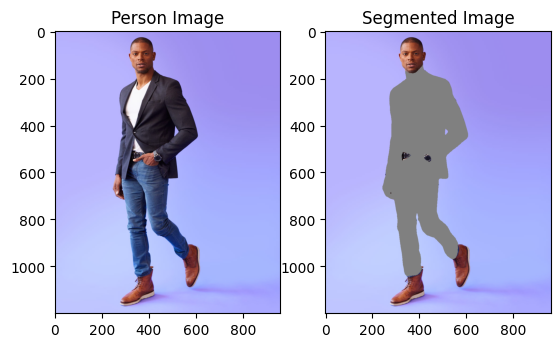

In [15]:
mask = cv2.imread(os.path.join(output_dir.split("/")[-1], person_file_name, "mask.png"), cv2.IMREAD_UNCHANGED)

cls_custom_classes = {
    "top": ['T-shirt/top','Shirt','Pullover'], # only upper body
    "long-pants": ['Trouser'], # pants and legs
    "shorts": ['Shorts'], # pants only
    "shoes": ['Sandal','Sneaker','Ankle Boot'],
    "Above-knee": ['Dress', 'Coat'], # whole body
    "whole-body": []
}

# upper body: upperclothers, dress, coat, torsoSkin, leftArm, rightArm
upper_body = [5, 6, 7, 14, 15, 10]
# lower_body: pants, skirt, leftLeg, rightLeg
lower_body = [9, 11, 16, 17]
# shorts: shorts
shorts = [9]
# shoes:
shoes = [8, 18, 19]


if class_name == "top":
    mask = np.where(np.isin(mask, upper_body), 1, 0)
elif class_name == "long-pants":
    mask = np.where(np.isin(mask, lower_body), 1, 0)
elif class_name == "shorts":
    mask = np.where(np.isin(mask, shorts), 1, 0)
elif class_name == "shoes":
    mask = np.where(np.isin(mask, shoes), 1, 0)
elif class_name == "Above-knee":
    mask = np.where(np.isin(mask, upper_body + shorts), 1, 0)
elif class_name == "whole-body":
    mask = np.where(np.isin(mask, upper_body + lower_body), 1, 0)

image = cv2.imread(person_img_path[1:])
image[mask == 1, :] = [128, 128, 128]
cv2.imwrite(os.path.join(output_dir.split("/")[-1], person_file_name, "mask_vton.png"), image)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
plt.title("Person Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Image")